In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("FraudDetection") \
    .master("local[*]") \
    .config("spark.hadoop.fs.defaultFS", "hdfs://namenode:8020") \
    .getOrCreate()

In [4]:
hadoopConf = spark._jsc.hadoopConfiguration()
fs = spark._jvm.org.apache.hadoop.fs.FileSystem.get(hadoopConf)

path = spark._jvm.org.apache.hadoop.fs.Path("/user/hasanga/")
files = fs.listStatus(path)

for file in files:
    print(file.getPath())

hdfs://namenode:8020/user/hasanga/PS_20174392719_1491204439457_log.csv
hdfs://namenode:8020/user/hasanga/nameage.csv


In [3]:
df = spark.read.csv("hdfs://namenode:8020/user/hasanga/nameage.csv", header=True, inferSchema=True)
df.show(5)

+-------+---+-----------+
|   Name|Age|       City|
+-------+---+-----------+
|  Alice| 28|   New York|
|    Bob| 34|Los Angeles|
|Charlie| 22|    Chicago|
|  Diana| 30|    Houston|
|  Ethan| 25|    Phoenix|
+-------+---+-----------+
only showing top 5 rows



In [5]:
df = spark.read.csv("hdfs://namenode:8020/user/hasanga/PS_20174392719_1491204439457_log.csv", header=True, inferSchema=True)
df.show(5)

+----+--------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|step|    type|  amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+--------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|   1| PAYMENT| 9839.64|C1231006815|     170136.0|     160296.36|M1979787155|           0.0|           0.0|      0|             0|
|   1| PAYMENT| 1864.28|C1666544295|      21249.0|      19384.72|M2044282225|           0.0|           0.0|      0|             0|
|   1|TRANSFER|   181.0|C1305486145|        181.0|           0.0| C553264065|           0.0|           0.0|      1|             0|
|   1|CASH_OUT|   181.0| C840083671|        181.0|           0.0|  C38997010|       21182.0|           0.0|      1|             0|
|   1| PAYMENT|11668.14|C2048537720|      41554.0|      29885.86|M1230701703|      

In [6]:
df.printSchema()
df.describe().show()
df.groupBy("type").count().show()
df.select("isFraud", "isFlaggedFraud").groupBy("isFraud", "isFlaggedFraud").count().show()

root
 |-- step: integer (nullable = true)
 |-- type: string (nullable = true)
 |-- amount: double (nullable = true)
 |-- nameOrig: string (nullable = true)
 |-- oldbalanceOrg: double (nullable = true)
 |-- newbalanceOrig: double (nullable = true)
 |-- nameDest: string (nullable = true)
 |-- oldbalanceDest: double (nullable = true)
 |-- newbalanceDest: double (nullable = true)
 |-- isFraud: integer (nullable = true)
 |-- isFlaggedFraud: integer (nullable = true)

+-------+------------------+--------+------------------+-----------+-----------------+-----------------+-----------+------------------+------------------+--------------------+--------------------+
|summary|              step|    type|            amount|   nameOrig|    oldbalanceOrg|   newbalanceOrig|   nameDest|    oldbalanceDest|    newbalanceDest|             isFraud|      isFlaggedFraud|
+-------+------------------+--------+------------------+-----------+-----------------+-----------------+-----------+------------------+----

In [7]:
df = df.dropna()

In [8]:
from pyspark.sql.functions import col, isnan, when, count

df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+
|step|type|amount|nameOrig|oldbalanceOrg|newbalanceOrig|nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+
|   0|   0|     0|       0|            0|             0|       0|             0|             0|      0|             0|
+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+



In [9]:
from pyspark.ml.feature import StringIndexer

indexer = StringIndexer(inputCol="type", outputCol="typeIndex")
df = indexer.fit(df).transform(df)


In [10]:
from pyspark.ml.feature import VectorAssembler

feature_cols = ["typeIndex", "amount", "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df = assembler.transform(df)


In [11]:
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)


In [12]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol="features", labelCol="isFraud")
lr_model = lr.fit(train_data)


In [13]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

predictions = lr_model.transform(test_data)
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="isFraud")
auc = evaluator.evaluate(predictions)

print(f"Logistic Regression AUC: {auc}")


Logistic Regression AUC: 0.9736961874375815


In [14]:
!pip install matplotlib seaborn pandas plotly pyspark.pandas

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 302.9 kB/s eta 0:00:0000:0100:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 375.5/375.5 kB 446.1 kB/s eta 0:00:00a 0:00:01
  Created wheel for pyspark.pandas: filename=pyspark_pandas-0.0.7-py3-none-any.whl size=7834 sha256=1d628502c3a4a38704bc71a6ecb9bf39fcddac9052d721f0c7d1ce74a5246526
  Stored in directory: /home/jovyan/.cache/pip/wheels/2e/9f/8d/d2bfbf37b673e080fb05f436b66a5332cf01f684fb06e03a1d
Successfully built pyspark.pandas


In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Take a sample of data to plot
sample_df = df.sample(False, 0.01, seed=42).toPandas()  # 1% of data


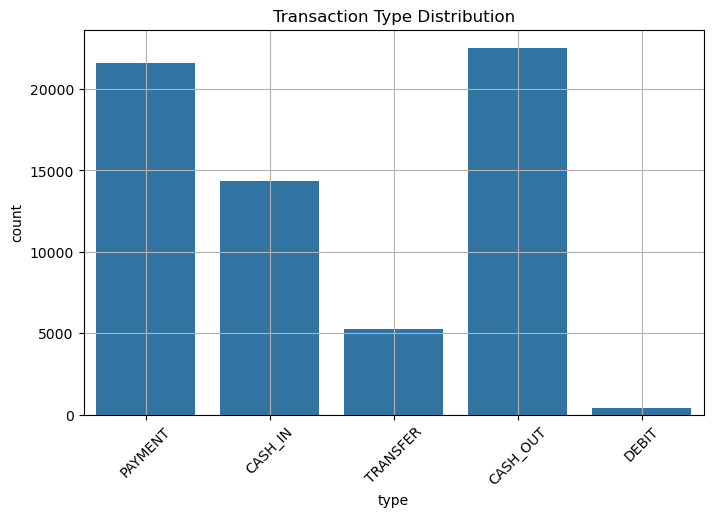

In [16]:
plt.figure(figsize=(8, 5))
sns.countplot(x='type', data=sample_df)
plt.title("Transaction Type Distribution")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


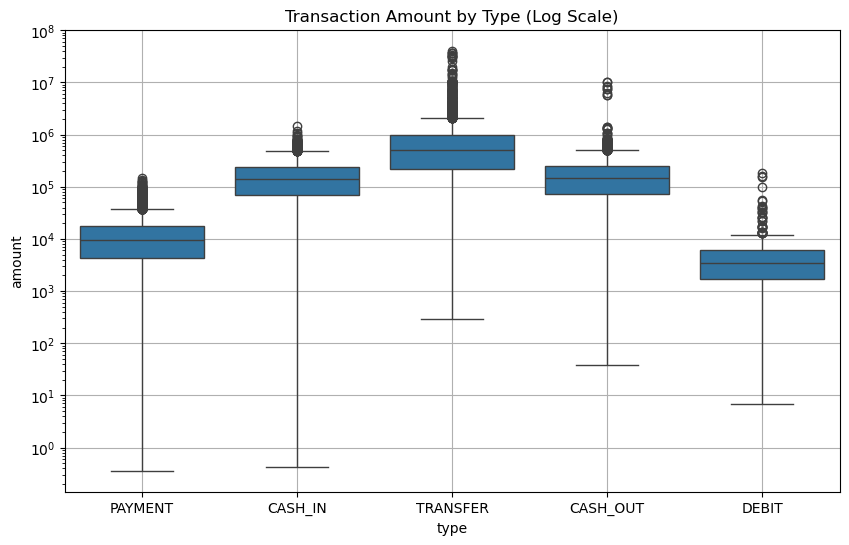

In [17]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='type', y='amount', data=sample_df)
plt.yscale('log')  # log scale because amount has large range
plt.title("Transaction Amount by Type (Log Scale)")
plt.grid(True)
plt.show()


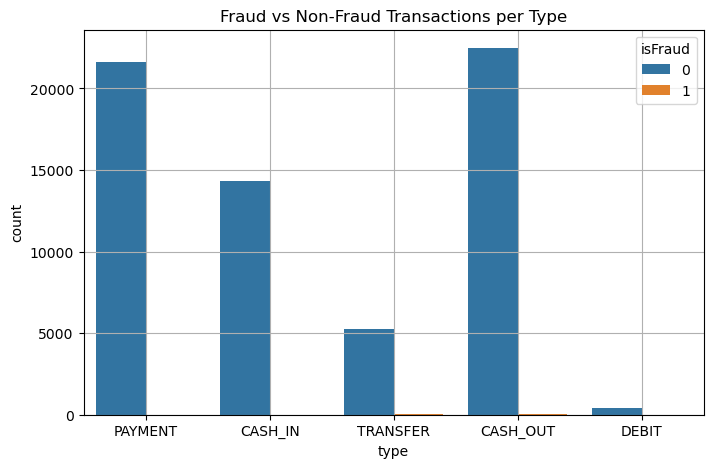

In [18]:
plt.figure(figsize=(8, 5))
sns.countplot(x='type', hue='isFraud', data=sample_df)
plt.title("Fraud vs Non-Fraud Transactions per Type")
plt.grid(True)
plt.show()


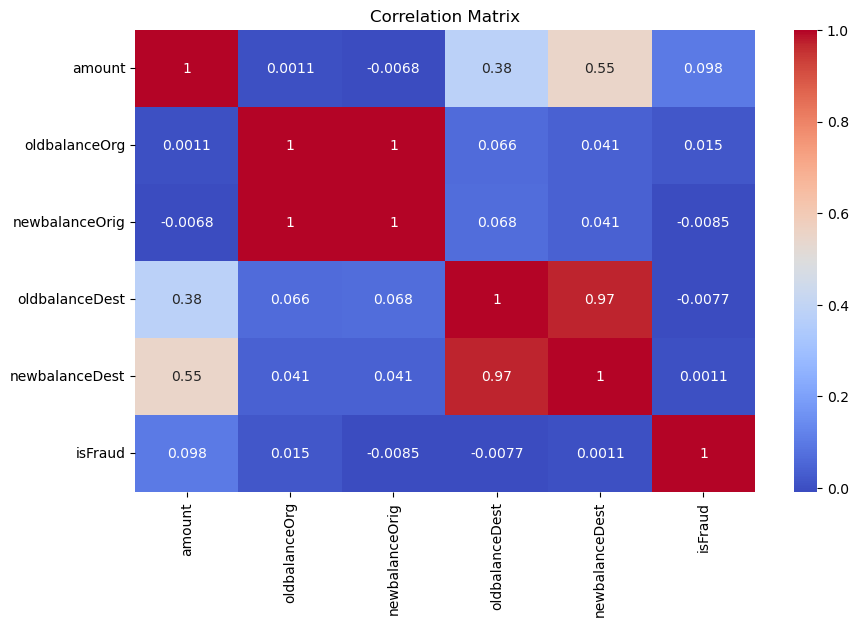

In [19]:
plt.figure(figsize=(10, 6))
sns.heatmap(sample_df[['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFraud']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()
